# Pandas Implementation of a Fisher-transformed Rolling Pearson Correlation for PRx

[Derek Merck](derek.merck@ufl.edu)  
University of Florida  
Spring, 2020


A [Fisher-transformed][] rolling [Pearson correlation][] is useful for computing the cerebral pressure reactivity index (PRx) from intracranial pressure (ICP) and mean arterial pressure (MAP) values.  PRx provides an index of patient cerebral pressure autoregulation after traumatic brain injury.

[Fisher-transformed]: https://en.wikipedia.org/wiki/Fisher_transformation
[Pearson correlation]:  https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

Steiner, Luzius A., Marek Czosnyka, Stefan K. Piechnik, Piotr Smielewski, Doris Chatfield, David K. Menon, and John D. Pickard. “Continuous Monitoring of Cerebrovascular Pressure Reactivity Allows Determination of Optimal Cerebral Perfusion Pressure in Patients with Traumatic Brain Injury.” Critical Care Medicine 30, no. 4 (April 2002): 733–38. https://doi.org/10.1097/00003246-200204000-00002.


In [47]:
import numpy as np
import pandas as pd

def fisher_transformed_rolling_pearson(obs1, obs2, w_sz):
    # Compares correlation of two sets of data samples
    # over a sliding window and returns a set of z-scores

    # Format as a data frame with 2 columns
    df = pd.DataFrame(np.array([obs1, obs2]).T)
    
    # Compute correlation along moving window
    _rp = df.rolling(w_sz).corr().loc[:,0][:,1]
    
    # Compute the Fisher r->z transform
    with np.errstate(invalid='ignore'):
        _ftrp = np.arctanh(_rp)
    
    return _ftrp.to_numpy()


def compute_prx(df, 
                sampling_target_rate="5T",
                correlation_window_size=5, 
                title=None):

    # Resample time series to appropriate frequency
    _df = df.resample(sampling_target_rate).mean()
    
    prx = fisher_transformed_rolling_pearson(
        _df["map"].to_numpy(),
        _df["icp"].to_numpy(),
        correlation_window_size
    )
    _df["prx"] = prx
    _df["cpp"] = _df["map"] - _df["icp"]
    
    _title = f"{title}-{sampling_target_rate}-{correlation_window_size}"         

    print(_title)
    print(_df.head())    
    _df.plot(subplots=True, title=_title)

    mu = _df["prx"].mean()
    print(f"Mean PRx: {mu}")
    
    return _df

def compute_cppopt(df, cpp_bins=5):
    
    _df = df.copy()
    _df.reset_index(inplace=True)
    _df = _df.sort_values("cpp")
    
    bins = pd.cut(_df["cpp"], bins=cpp_bins)
    cpp_cluster_means = _df.groupby(bins).agg("mean")
    cpp_cluster_means.rename({"prx": "mean_prx"}, axis=1, inplace=True)
    ax = cpp_cluster_means.plot(x="cpp", y="mean_prx", c="red", title="CppOpt")
    _df.plot.scatter(x="cpp", y="prx", ax=ax, label="prx")
    
# Setup globals
sampling_target_rate = "10T"  # T=minutes
correlation_window_size = 5
cpp_bins = 5


## Captured Data Example

This reads in a dataset from a `.csv` file and computes PRx.  Sample data is 6 hours with a 2 sec period.  Headers should be `sec`, `icp`, and `map`.


Observed-10T-5
                       map        icp       prx        cpp
sec                                                       
1970-01-01 00:00:00  90.00  14.016667       NaN  75.983333
1970-01-01 00:10:00  90.00  10.603333       NaN  79.396667
1970-01-01 00:20:00  90.00  10.763333       NaN  79.236667
1970-01-01 00:30:00  88.58  11.206667       NaN  77.373333
1970-01-01 00:40:00  88.00   1.256667  1.017767  86.743333
Mean PRx: -0.0006525706671639169


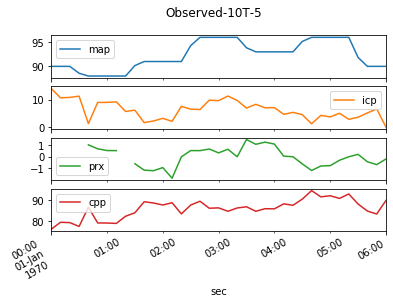

In [48]:

def get_csv_obs(fn):
    # Data comes in seconds
    df = pd.read_csv(fn)
    df = df.astype({"sec": 'datetime64[s]'})
    df = df.set_index("sec")
    return df

title = "Observed"
df = get_csv_obs("test.csv")
df2 = compute_prx(df,
            sampling_target_rate,
            correlation_window_size,
            title)



`cpp` is the difference `map-icp`.  `CppOpt` is computed by binning `prx` values by `cpp`, fitting a curve through the data, and finding the min.  

This does not seem to yields much insight, practically.  `cpp` is dominated by `map`, which is an order of magnitude larger than `icp`, so this reduces to "for what values of `map` is `prx` minimized."  And `map` does not vary that much for these sample data.


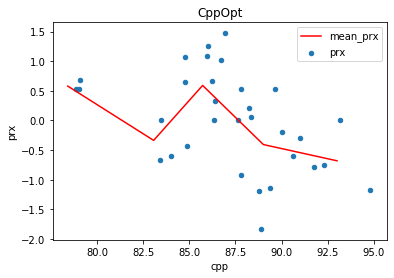

In [49]:

compute_cppopt(df2, cpp_bins)


## Correlated Data Examples

These examples generate datasets of similar size to the live data with artificially induced correlation.

This example simulates independent variables; the mean prx is usually near 0


Independent-10T-5
                            map        icp       prx        cpp
1970-01-01 00:00:00  100.211063   9.983792       NaN  90.227272
1970-01-01 00:10:00   99.943181   9.973560       NaN  89.969621
1970-01-01 00:20:00   99.898556   9.974531       NaN  89.924024
1970-01-01 00:30:00  100.179000  10.169200       NaN  90.009799
1970-01-01 00:40:00   99.784214   9.926646  0.812145  89.857567
Mean PRx: 0.021010847371864087


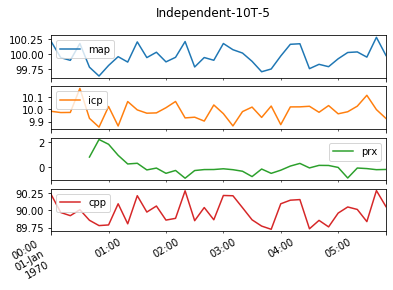

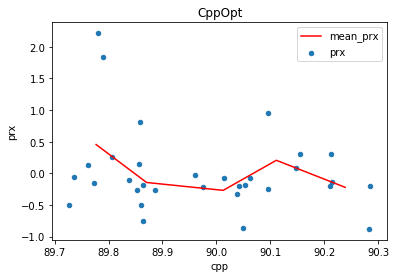

In [50]:

def get_correlated_obs(mean, cov, n_obs):
    obs = np.random.multivariate_normal(mean, cov, n_obs).T
    df = pd.DataFrame(
        {"map": obs[0,:],
         "icp": obs[1,:]},
        index = pd.date_range(start=0, 
                              periods=n_obs, 
                              freq="2S")
    )
    return df
    
n_obs = 60 * 60 * 6 // 2  # 6hrs of 1 obs/2 sec
mean = [100,10]  # MAP is O(100), ICP is O(10)

title = "Independent"
cov = [[10, 0], [0, 1]]

df = get_correlated_obs(mean, cov, n_obs)
df2 = compute_prx(df,
            sampling_target_rate,
            correlation_window_size,
            title)
compute_cppopt(df2, cpp_bins)


This example simulates correlated variables; the mean prx is usually greater than 0, which is _bad_.


Correlated-10T-5
                            map        icp       prx        cpp
1970-01-01 00:00:00  100.230972   9.944821       NaN  90.286151
1970-01-01 00:10:00  100.177210  10.078211       NaN  90.098998
1970-01-01 00:20:00  100.185245  10.111634       NaN  90.073611
1970-01-01 00:30:00   99.917942  10.036087       NaN  89.881855
1970-01-01 00:40:00   99.939230  10.001523  0.082925  89.937707
Mean PRx: 0.7019534796542601


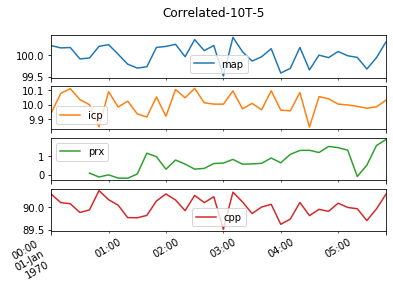

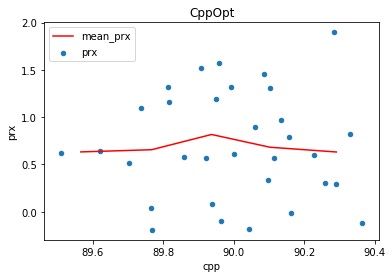

In [51]:

title = "Correlated"
cov = [[10, 2], [2, 1]]

df = get_correlated_obs(mean, cov, n_obs)
df2 = compute_prx(df,
            sampling_target_rate,
            correlation_window_size,
            title)
compute_cppopt(df2, cpp_bins)


This example simulates anti-correlated variables; the mean prx is usually less than 0, which is _good_.


Anti-correlated-10T-5
                            map        icp       prx        cpp
1970-01-01 00:00:00   99.859603  10.070110       NaN  89.789493
1970-01-01 00:10:00   99.829270  10.022556       NaN  89.806714
1970-01-01 00:20:00   99.918435  10.083829       NaN  89.834606
1970-01-01 00:30:00  100.340058   9.904695       NaN  90.435363
1970-01-01 00:40:00   99.817992  10.029153 -1.273202  89.788839
Mean PRx: -1.3133065280854044


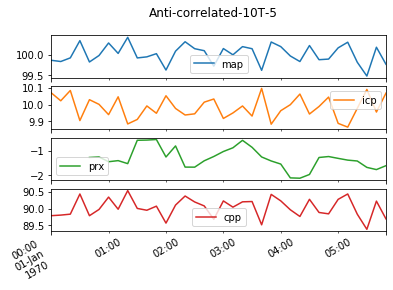

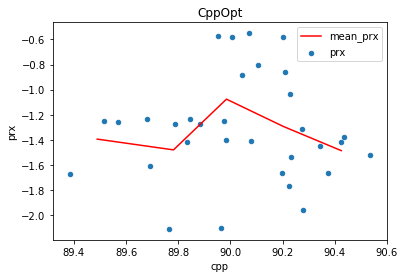

In [52]:
title = "Anti-correlated"
cov = [[10, -2], [-2, 1]]

df = get_correlated_obs(mean, cov, n_obs)
df2 = compute_prx(df,
            sampling_target_rate,
            correlation_window_size,
            title)
compute_cppopt(df2, cpp_bins)

